<h1 align='center'><b><font color='indianred'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


# <font color='indianred'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe.

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





##**Installing/Importing libraries**

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
import sys

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [115]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !python -m spacy download en_core_web_sm -qq

    basepath = '/content/drive/MyDrive/6342_NLP_COURSE'
    sys.path.append('/content/drive/MyDrive/6342_NLP_COURSE/model')
else:
   sys.path.append('/content/drive/MyDrive/6342_NLP_COURSE/model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [116]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/6342_NLP_COURSE/model',
 '/content/drive/MyDrive/6342_NLP_COURSE/model',
 '/content/drive/MyDrive/6342_NLP_COURSE/model']

In [117]:
!pip install pyspellchecker

In [118]:
import CustomPreprocessorSpacy as cp
from FeaturizerSpacy import ManualFeatures
from plot_learning_curve import plot_learning_curve

In [119]:
base_folder = Path(basepath)
data_folder = base_folder/'Datasets'
model_folder = base_folder/'model'

In [120]:
model_folder.mkdir(exist_ok=True, parents=True)

In [121]:
# Load the CSV file
file_path = data_folder / 'spam.csv'

In [130]:
file_path

PosixPath('/content/drive/MyDrive/6342_NLP_COURSE/Datasets/spam.csv')

In [131]:
spam_data = pd.read_csv(file_path, encoding="latin-1")

In [132]:
# print shape of the datasets
print(f'Shape of Spam data set is : {spam_data.shape}')

Shape of Spam data set is : (5572, 5)


In [133]:
# Printing top 5 train records
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [134]:
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

spam_data = spam_data.drop(columns=columns_to_drop)

In [135]:
final_Spam_data = spam_data.rename(columns={"v1":"label", "v2":"message"})

In [136]:
# diaplay first five rows
final_Spam_data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [137]:
label_counts = final_Spam_data['label'].value_counts()

In [138]:
print(f"Percentage of ham messages: {((label_counts['ham'] / len(final_Spam_data)) * 100):.2f}%")
print(f"Percentage of spam messages: {((label_counts['spam'] / len(final_Spam_data)) * 100):.2f}%")

Percentage of ham messages: 86.59%
Percentage of spam messages: 13.41%


# <font color='indianred'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

**Answer:**
Since in our dataset we can see that most of the messages are labelled as ham and only few are labelled as spam. So, if we rely completely on accuracy it wont be a correct metric to evaluate the model.

Considering the imbalanced nature of the dataset, we should choose the F1 score as the primary metric for evaluating the model. The F1 score is the harmonic mean of Precision and Recall, making it a more balanced metric that considers both false positives and false negatives. Additionally, I would also consider Precision and Recall separately to gain a deeper understanding of the model's ability to correctly classify 'spam' messages (Precision) and its capability to identify the actual 'spam' messages in the dataset (Recall).



# <font color='indianred'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model.

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 5-10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:**

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/).

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.).

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn:

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





In [139]:
import numpy as np

In [140]:
final_Spam_data['label'] = np.where(final_Spam_data['label'] == 'spam', 1, 0)

In [141]:
print(final_Spam_data['label'].unique())


[0 1]


In [142]:
from sklearn.model_selection import train_test_split

In [145]:
spam_big_data = final_Spam_data.sample(frac = 0.9, replace = True, random_state = 1)

In [146]:
y = spam_big_data['label']
x = spam_big_data['message']


In [147]:
spam_big_train, spam_big_test = train_test_split(spam_big_data, test_size = 0.2, stratify= y,random_state = 6)

In [148]:
X_train = spam_big_train['message'].values
X_test = spam_big_test['message'].values
y_train = spam_big_train['label'].values
y_test = spam_big_test['label'].values

In [149]:
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (4012,) y_train: (4012,)
X_test: (1003,) y_test: (1003,)


In [150]:
X_train_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_train)

/content/drive/MyDrive/6342_NLP_COURSE/model/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [151]:
# save  this to a file
file_X_train_cleaned_bow = data_folder / 'x_train_cleaned_bow_small.pkl'
joblib.dump(X_train_cleaned_bow, file_X_train_cleaned_bow)

['/content/drive/MyDrive/6342_NLP_COURSE/Datasets/x_train_cleaned_bow_small.pkl']

In [152]:
X_test_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_test)

In [153]:
# save  this to a file
file_X_test_cleaned_bow = data_folder / 'x_test_cleaned_bow_small.pkl'
joblib.dump(X_test_cleaned_bow, file_X_test_cleaned_bow)


['/content/drive/MyDrive/6342_NLP_COURSE/Datasets/x_test_cleaned_bow_small.pkl']

## **3. Sparse Embeddings (TF-IDF) + Feature Engineering + ML**

In [158]:
X_train_cleaned_bow = joblib.load(file_X_train_cleaned_bow)

In [160]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [161]:
X_train_features, feature_names = featurizer.fit_transform(X_train)

In [162]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_bow, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

In [163]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner,spelling_mistakes,digit_count,exclamation_mark_count,proper_noun_count
0,friend priest,12.0,48.0,37.0,2.846154,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fair go,5.0,31.0,27.0,4.500000,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
2,dear know < > th < > th birthday love gopa...,47.0,242.0,196.0,4.083333,0.0,4.0,10.0,3.0,7.0,4.0,2.0,7.0,0.0,0.0,0.0
3,hcl chennai require fresher voice process exce...,25.0,167.0,146.0,5.615385,0.0,3.0,16.0,0.0,2.0,1.0,5.0,10.0,0.0,0.0,0.0
4,hank lotsly,2.0,13.0,12.0,4.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [164]:
subset = X_train_final[0:10]


In [165]:
subset.shape

(10, 16)

In [166]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)


In [167]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [168]:
sparse_features.fit_transform(subset.iloc[:, 1:])

<10x15 sparse matrix of type '<class 'numpy.float64'>'
	with 96 stored elements in Compressed Sparse Row format>

In [169]:
vectorizer.fit_transform(subset.iloc[:, 0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [171]:
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)

In [172]:
test = combined_features.fit_transform(subset)

In [173]:
test.dtype


dtype('float64')

In [174]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                         ])

In [175]:
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                            'classifier__C': [1,10,100,1000,50000,100000,250000],
                            'classifier__class_weight': ['balanced']
                           }

In [176]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=3, scoring = 'f1')

In [177]:
# Fit the model on training data
grid_classifier_3.fit(X_train_final, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [1, 10, 100, 1000, 50000, 100000,
                                           250000],
                         'classifier__class_weight': ['balanced'],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                                                           1000,
                                                                           2000]},
             scoring='f1')

In [178]:
print(
    "Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'classifier__C': 1000, 'classifier__class_weight': 'balanced', 'combined_features__tfidf__tfidf__max_features': 2000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    max_iter=10000))])


In [180]:
file_best_estimator_pipeline3_round1 = model_folder / \
    'pipeline3_round1_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = model_folder / \
    'pipeline3_round1_complete_grid.pkl'


In [ ]:
joblib.dump(grid_classifier_3.best_estimator_,
            file_best_estimator_pipeline3_round1)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_round1)

['/content/drive/MyDrive/6342_NLP_COURSE/model/pipeline3_round1_complete_grid.pkl']

In [181]:
# load the saved model
best_estimator_pipeline3_round1 = joblib.load(
    file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(
    file_complete_grid_pipeline3_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

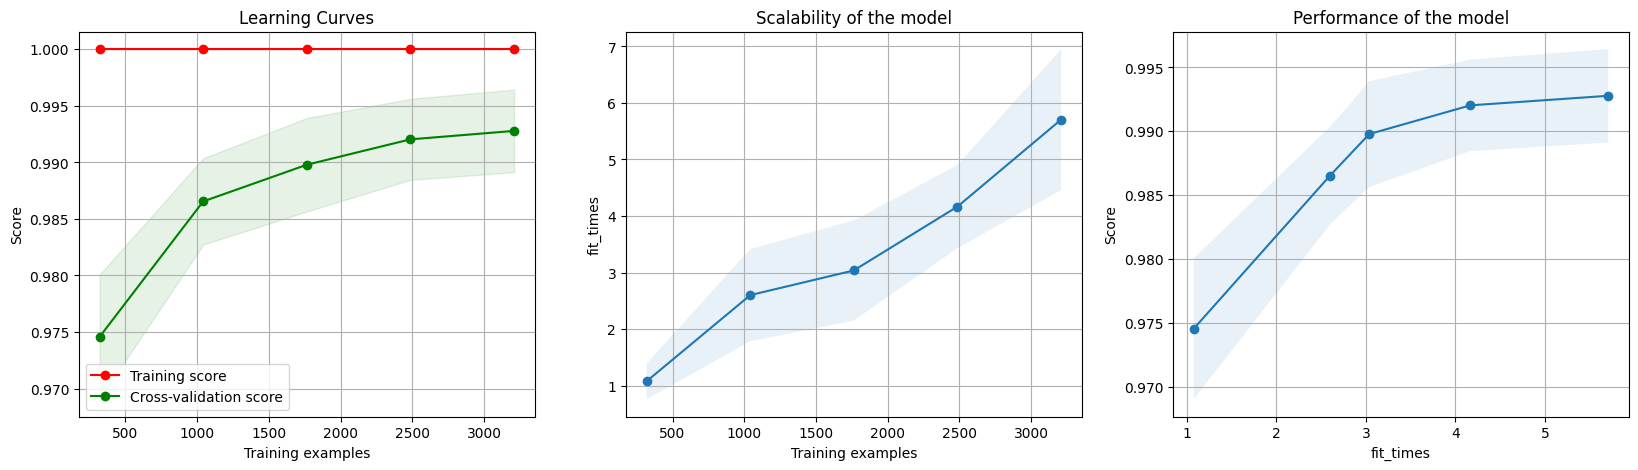

In [183]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1)


In [184]:
# let's check the train scores
print(best_estimator_pipeline3_round1.score(X_train_final, y_train))

# let's check the cross validation score
print(complete_grid_pipeline3_round1.best_score_)


0.9820538384845464
0.9338624338624338


In [185]:
X_test.shape

(1003,)

In [186]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 1000).transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_bow)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(
        file_best_estimator_pipeline3_round1)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [187]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [188]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))



Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       874
           1       0.96      0.94      0.95       129

    accuracy                           0.99      1003
   macro avg       0.98      0.97      0.97      1003
weighted avg       0.99      0.99      0.99      1003

